In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from hourglass import StackedHourglassNetwork

"""gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)"""

"gpus = tf.config.experimental.list_physical_devices('GPU')\nif gpus:\n  try:\n    for gpu in gpus:\n      tf.config.experimental.set_memory_growth(gpu, True)\n  except RuntimeError as e:\n    print(e)"

In [2]:
model = StackedHourglassNetwork(num_heatmap=68)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

In [2]:
from binary_hourglass import binary_stacked_hourglass

model = binary_stacked_hourglass(num_stack=1)

model.compile(optimizer='adam', loss='mse')

model.summary()

TypeError: binary_hourglass() got an unexpected keyword argument 'num_stacks'

In [2]:
import os
from joblib import Parallel, delayed
from collections import defaultdict
from timeit import default_timer as timer
import re

def load_data():
    parent_dir = './data/training/'
    
    paths = defaultdict(bool) # using the keys to record each unique path
                              # without the extension
    print('Loading file paths')
    
    filenames = os.listdir(parent_dir)

    for f in filenames:
        num, _ = re.split('\.', f)
        paths['{}{}'.format(parent_dir, num)] = True
    
    new_ids = [(i, path) for i, path in enumerate(paths.keys())]
    
    n_jobs = 4
    executor = Parallel(n_jobs=n_jobs, backend='multiprocessing', 
                        prefer='processes', verbose=1)
    
    count = len(paths)
    
    print('Loading and converting {} file pairs'.format(count))
    start = timer()
    data = executor(delayed(load_example)(path) for path in new_ids)
    total_time = timer() - start
    
    print('Time to load {} image label pairs: {}\nAverage time per pair: {}'.format(count, total_time, total_time/count))
    print('Pairs per second: {}'.format(count / total_time))
    return data

def load_filenames():
    #return list(range(len(os.listdir('./data/preprocessed_training/')) // 2))
    nums = defaultdict(bool)

    for f in os.listdir('./data/training/'):
        num, _ = re.split('\.',f)
        nums[num] = True
        
    train = ['./data/training/' + f for f in list(nums.keys())]
    
    nums = defaultdict(bool)

    for f in os.listdir('./data/testing/'):
        num, _ = re.split('\.',f)
        nums[num] = True
    
    
    return train, ['./data/testing/' + f for f in list(nums.keys())]

In [3]:
import torchfile
import os
import numpy as np
from shutil import copyfile
import re
from collections import defaultdict
from tqdm import tqdm

parent_dir = './data/LS3D-W/300VW-3D/'
dest = './data/training/'
skipped_count = 0

def steps(start,end,n):
    step = (end-start)/float(n-1)
    return [int(round(start+x*step)) for x in range(n)]

def get_unique(filenames):
    unique = defaultdict(bool)
    for f in filenames:
        num, _ = re.split('\.', f)
        unique[num] = True
    return sorted(list(unique.keys()))

def load_move(fp, num):
    if os.path.exists(fp + '.jpg') and os.path.exists(fp + '.t7'):
        copyfile(fp + '.jpg', dest + num + '.jpg')
        converted = np.array(torchfile.load(fp + '.t7'))
        np.save(dest + num + '.npy', converted)

        return True
    else:
        return False
#a, b = load_filenames()
#filenames = a

categories = os.listdir(parent_dir)
folders = []

for c in categories:
    folders.extend([parent_dir + c + '/' + folder + '/' for folder in os.listdir(parent_dir + c)])

for fp in tqdm(folders, smoothing=0):
    filenames = os.listdir(fp)
    folder_size = len(filenames) // 2

    nums = get_unique(filenames)

    for i in steps(0,folder_size - 1,351):
        moved = load_move(fp + nums[i], nums[i])

        if not moved:
            skipped_count+=1

print(skipped_count)

100%|██████████| 114/114 [00:42<00:00,  2.67it/s]132



In [4]:
import keras
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
from imgaug.augmentables.batches import UnnormalizedBatch
import torchfile
from multiprocessing import Pool
from PIL import Image
from scipy.stats import multivariate_normal

def loader(num):
    try:
        img = np.asarray(Image.open(num + '.jpg'))
    except:
        img = Image.open(num + '.png')
        if type(img.getpixel((0,0))) == int:
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
            img = rgbimg
        img = np.asarray(img)
    
    #print(img.shape)
    #print(np.load(num + '.npy').shape)
    return (img, np.load(num + '.npy'))
    """return (imageio.imread('./data/training/' + str(num) + '.jpg'), 
            torchfile.load('./data/training/' + str(num) + '.t7'))"""
    """return (np.array(image.load_img('./data/training/' + str(num) + '.jpg')), 
            torchfile.load('./data/training/' + str(num) + '.t7'))"""

class My_Custom_Generator(keras.utils.Sequence):

    def __init__(self, ids, batch_size, sub_batch_count, image_shape):
        self.ids = ids
        self.batch_size = batch_size
        self.downscaling = image_shape[0] / 64
        self.x_batch_shape = (batch_size,) + image_shape
        self.y_batch_shape = (batch_size, 68, 2)
        self.aug = iaa.Sequential([
            iaa.CropToAspectRatio(1),
            iaa.Resize({"height": 256, "width": 256}),
            iaa.Fliplr(0.5),
            iaa.Affine(translate_px={"x": (6, 20)}, 
            rotate=(-10, 10)),
            iaa.AddToHueAndSaturation((-15, 15))])
        #self.pool = self.aug.pool(processes=sub_batch_count, maxtasksperchild=20)
        self.converter = np.array(image_shape)
        self.sub_batch_count = sub_batch_count
        self.chunk_size = batch_size // sub_batch_count
        #self.file_loader_pool = Pool(4)

    def __len__(self) :
        return (np.ceil(len(self.ids) / float(self.batch_size))).astype(np.int)
    
    def xy_to_heatmap(self, xy):
        mean = [int(xy[1] / self.downscaling), int(xy[0] / self.downscaling)]
        #print('{} -> {}'.format([xy[1], xy[0]], mean))

        pos = np.dstack(np.mgrid[0:64:1, 0:64:1])
        rv = multivariate_normal(mean=mean, cov=4)

        return rv.pdf(pos)
    
    def __getitem__(self,idx):
        batch_ids = self.ids[idx * self.batch_size : (idx+1) * self.batch_size]
        #images = [imageio.imread('./data/training/' + str(num) + '.jpg') for num in batch_ids]
        #keypoints = [torchfile.load('./data/training/' + str(num) + '.t7') for num in batch_ids]
        #files = self.file_loader_pool.map(loader, batch_ids)
        files = list(map(loader, batch_ids))
        batch_x = [tup[0] for tup in files]
        batch_y = [tup[1] for tup in files]
        #batches = [UnnormalizedBatch(images=images[i:i+self.chunk_size], keypoints=keypoints[i:i+self.chunk_size]) for i in range(0, self.batch_size, self.chunk_size)]
        #batch = UnnormalizedBatch(images=images, keypoints=keypoints)

        #batch_x = []
        #batch_y = []
        #print(np.mean(batch_y[0]))
            
        batch_x, batch_y = self.aug(images=batch_x, keypoints=batch_y)

        #print(batch_y[0][:,1])
        #print((np.mean(batch_y[0][:,0]), np.mean(batch_y[0][:,1])))

        #keypoints = np.array(batch_y)
        
        batch_y = [list(map(self.xy_to_heatmap, kps)) for kps in batch_y]
        batch_y = np.asarray(batch_y)
        batch_y = np.moveaxis(batch_y, 1, -1)
        #print(batch_ids)
        return np.asarray(batch_x), batch_y
                #return np.asarray(aug_x), np.asarray(aug_y) / self.converter
            #return aug_x.images_aug, aug

In [5]:
import json
import imgaug as ia
import imgaug.augmenters as iaa
class train_generator(keras.utils.Sequence):
    def __init__(self):
        with open('./data/train_params.json') as f:
            params = json.load(f)
        self.ids = params['ids']
        self.batch_size = params['batch_size']
        self.image_shape = params['image_shape']
        self.downscaling = 256/64

        self.aug = iaa.Sequential([
            iaa.CropToAspectRatio(1),
            iaa.Resize({"height": 256, "width": 256}),
            iaa.Fliplr(0.5),
            iaa.Affine(scale=(0.7, 1.3), rotate=(-40, 40))])
        
        """self.kp_aug = iaa.Resize({"height": 64, "width": 64})
        self.aug = iaa.Sequential([
            iaa.CropToAspectRatio(1),
            iaa.Resize({"height": 256, "width": 256}),
            iaa.Fliplr(0.5),
            iaa.Affine(translate_px={"x": (3, 10)}, 
            rotate=(-10, 10)),
            iaa.AddToHueAndSaturation((-5, 5))])"""
    def __len__(self) :
        return (np.ceil(len(self.ids) / float(self.batch_size))).astype(np.int)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        while 1:
            for item in (self[i] for i in range(len(self))):
                yield item

    def xy_to_heatmap(self, xy):
        mean = [int(xy[1] / self.downscaling), int(xy[0] / self.downscaling)]
        #print('{} -> {}'.format([xy[1], xy[0]], mean))

        pos = np.dstack(np.mgrid[0:64:1, 0:64:1])
        rv = multivariate_normal(mean=mean, cov=4)

        return rv.pdf(pos)
    def load(self, num):
        img = np.asarray(Image.open(num + '.jpg'))
        return (img, np.load(num + '.npy'))

    def get_y_as_heatmap(self, kps,height,width, sigma):
        def generate_hm(height, width ,landmarks,s=3):
            """ Generate a full Heap Map for every landmarks in an array
            Args:
                height    : The height of Heat Map (the height of target output)
                width     : The width  of Heat Map (the width of target output)
                joints    : [(x1,y1),(x2,y2)...] containing landmarks
                maxlenght : Lenght of the Bounding Box
            """
            def gaussian_k(x0,y0,sigma, width, height):
                """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
                """
                x = np.arange(0, width, 1, float) ## (width,)
                y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
                return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

            Nlandmarks = len(landmarks)
            hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
            for i in range(Nlandmarks):
                if not np.array_equal(landmarks[i], [-1,-1]):
                
                    hm[:,:,i] = gaussian_k(landmarks[i][0],
                                            landmarks[i][1],
                                            s,height, width)
                else:
                    hm[:,:,i] = np.zeros((height,width))
            return hm
        
        y_train = []
        for i in range(kps.shape[0]): 
            y_train.append(generate_hm(height, width, kps[i], sigma))

        y_train = np.array(y_train)
    
    
        return y_train

    def __getitem__(self,idx):
        batch_ids = self.ids[idx * self.batch_size : (idx+1) * self.batch_size]
        files = list(map(self.load, batch_ids))
        batch_x = [tup[0] for tup in files]
        batch_y = [tup[1] for tup in files]

        batch_x, batch_y = self.aug(images=batch_x, keypoints=batch_y)
        
        #batch_y = self.kp_aug(keypoints=batch_y, shape=(256,256))
        batch_y = np.array(batch_y)
        batch_y = batch_y / self.downscaling
        batch_y = self.get_y_as_heatmap(batch_y, 64, 64, 2)
        #batch_y = [list(map(self.xy_to_heatmap, kps)) for kps in batch_y]
        #batch_y = np.asarray(batch_y)
        #batch_y = np.moveaxis(batch_y, 1, -1)
        return np.asarray(batch_x), batch_y

class val_generator(keras.utils.Sequence):
    def __init__(self):
        with open('./data/val_params.json') as f:
            params = json.load(f)
        self.ids = params['ids']
        self.batch_size = params['batch_size']
        self.image_shape = params['image_shape']
        self.downscaling = 256/64
        self.aug = iaa.Sequential([
            iaa.CropToAspectRatio(1),
            iaa.Resize({"height": 256, "width": 256})])
        
        """self.kp_aug = iaa.Resize({"height": 64, "width": 64})
        self.aug = iaa.Sequential([
            iaa.CropToAspectRatio(1),
            iaa.Resize({"height": 256, "width": 256}),
            iaa.Fliplr(0.5),
            iaa.Affine(translate_px={"x": (3, 10)}, 
            rotate=(-10, 10)),
            iaa.AddToHueAndSaturation((-5, 5))])"""

    def __len__(self) :
        return (np.ceil(len(self.ids) / float(self.batch_size))).astype(np.int)
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        while 1:
            for item in (self[i] for i in range(len(self))):
                yield item
    def xy_to_heatmap(self, xy):
        mean = [int(xy[1] / self.downscaling), int(xy[0] / self.downscaling)]
        #print('{} -> {}'.format([xy[1], xy[0]], mean))

        pos = np.dstack(np.mgrid[0:64:1, 0:64:1])
        rv = multivariate_normal(mean=mean, cov=4)

        return rv.pdf(pos)
    
    def load(self, num):
        img = Image.open(num + '.png')
        if type(img.getpixel((0,0))) == int:
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
            img = rgbimg
        img = np.asarray(img)
        #img = np.asarray(Image.open(num + '.jpg'))
        return (img, np.load(num + '.npy'))


    def get_y_as_heatmap(self, kps,height,width, sigma):
        def generate_hm(height, width ,landmarks,s=3):
            """ Generate a full Heap Map for every landmarks in an array
            Args:
                height    : The height of Heat Map (the height of target output)
                width     : The width  of Heat Map (the width of target output)
                joints    : [(x1,y1),(x2,y2)...] containing landmarks
                maxlenght : Lenght of the Bounding Box
            """
            def gaussian_k(x0,y0,sigma, width, height):
                """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
                """
                x = np.arange(0, width, 1, float) ## (width,)
                y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
                return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

            Nlandmarks = len(landmarks)
            hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
            for i in range(Nlandmarks):
                if not np.array_equal(landmarks[i], [-1,-1]):
                
                    hm[:,:,i] = gaussian_k(landmarks[i][0],
                                            landmarks[i][1],
                                            s,height, width)
                else:
                    hm[:,:,i] = np.zeros((height,width))
            return hm
        
        y_train = []
        for i in range(kps.shape[0]): 
            y_train.append(generate_hm(height, width, kps[i], sigma))

        y_train = np.array(y_train)
    
    
        return y_train

    def __getitem__(self,idx):
        batch_ids = self.ids[idx * self.batch_size : (idx+1) * self.batch_size]
        files = list(map(self.load, batch_ids))
        batch_x = [tup[0] for tup in files]
        batch_y = [tup[1] for tup in files]

        batch_x, batch_y = self.aug(images=batch_x, keypoints=batch_y)
        
        #batch_y = self.kp_aug(keypoints=batch_y, shape=(256,256))
        batch_y = np.array(batch_y)
        batch_y = batch_y / self.downscaling
        batch_y = self.get_y_as_heatmap(batch_y, 64, 64, 2)
        #batch_y = [list(map(self.xy_to_heatmap, kps)) for kps in batch_y]
        #batch_y = np.asarray(batch_y)
        #batch_y = np.moveaxis(batch_y, 1, -1)
        return np.asarray(batch_x), batch_y
    
def get_train_dataset(self):
    self = tf.data.Dataset.from_generator(
        train_generator,
        output_types = (tf.float32, tf.float32))
    return self

def get_val_dataset(self):
    self = tf.data.Dataset.from_generator(
        val_generator,
        output_types = (tf.float32, tf.float32))
    return self


In [6]:
import random
import json
train_ids, val_ids = load_filenames()
random.shuffle(train_ids)
random.shuffle(val_ids)

batch_size = 16
image_shape = (256,256,3)

train_params = {
    'ids': train_ids,
    'batch_size': batch_size,
    'image_shape': image_shape
}
val_params = {
    'ids': val_ids,
    'batch_size': batch_size,
    'image_shape': image_shape
}
json.dump(train_params, open('./data/train_params.json', 'w'))
json.dump(val_params, open('./data/val_params.json', 'w'))

#print(int(len(train_ids) // batch_size))
#print(np.ceil(len(train_ids) / float(batch_size)))

train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_types = (tf.float32, tf.float32))

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types = (tf.float32, tf.float32))

In [7]:
if i >= batch_size:
    i=0
keypoints = heatmaps_to_keypoints(y[i])
plot_keypoints(np.array(x[i]), keypoints)
i+=1
#plot_literal_points(np.array(x[i]), kps[i])
#imshow(x[i])
#imshow(np.vstack((np.hstack(y[i][:15]), np.hstack(y[i][15:30]), np.hstack(y[i][30:45]), np.hstack(y[i][45:60]))))

NameError: name 'heatmaps_to_keypoints' is not defined

In [8]:
from matplotlib.pyplot import imshow

def plot_literal_points(data, points, show=True):
    size = len(data) - 1
    color = (0,255,255)
    h = size
    w = len(data[0]) - 1
    
    for x, y in points:
        #x = int(xr * w)
        #y = int(yr * h)
        x = int(x)
        y = int(y)
        
        x = max(x, 0)
        x = min(x, w - 1)
        y = max(y, 0)
        y = min(y, h-1)
        
        data[y][x] = color

        if y > 0:
            data[y-1][x] = color
        if x > 0:
            data[y][x-1] = color
        if x < w:
            data[y][x+1] = color
        if y < h:
            data[y+1][x] = color
    if show:
        imshow(data.astype(np.uint8))

def plot_keypoints(data, points, show=True):
    size = len(data) - 1
    color = (0,255,0)
    h = size
    w = len(data[0]) - 1
    
    for xr, yr in points:
        x = int(xr * w)
        y = int(yr * h)
        
        x = max(x, 0)
        x = min(x, w - 1)
        y = max(y, 0)
        y = min(y, h-1)
        
        data[y][x] = color

        if y > 0:
            data[y-1][x] = color
        if x > 0:
            data[y][x-1] = color
        if x < w:
            data[y][x+1] = color
        if y < h:
            data[y+1][x] = color
    if show:
        imshow(data.astype(np.uint8))

def ratio_to_absolute(keypoints, image_size):
    return keypoints * np.array(image_size)

In [9]:
from keras.layers import Input, Dense, Add, Conv2D, UpSampling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout,concatenate, Concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

def loss_wrapper(layer):
    def custom_loss(labels, output):
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        loss = tf.math.reduce_mean(tf.math.square(labels - output) * weights)
        return loss
    
    mse = tf.keras.losses.MeanSquaredError()

    return mse

def residual_module(input_features):
    conv = Conv2D(128, (1,1), padding='same', activation='relu')(input_features)
    conv = Conv2D(128, (3,3), padding='same', activation='relu')(conv)
    conv = Conv2D(256, (1,1), padding='same', activation='relu')(conv)
    return Add()([conv,input_features])

def hourglass(input_features):
    # downscaling half
    res1 = residual_module(input_features)
    pool = MaxPooling2D((2,2))(res1)
    res2 = residual_module(pool)
    pool = MaxPooling2D((2,2))(res2)
    res3 = residual_module(pool)
    pool = MaxPooling2D((2,2))(res3)
    res4 = residual_module(pool)
    pool = MaxPooling2D((2,2))(res4)
    
    # block of 3 residual modules w/ no pooling
    mini_res = residual_module(pool)
    mini_res = residual_module(mini_res)
    mini_res = residual_module(mini_res)
    
    # residual module for each of the unpooled outputs
    res1 = residual_module(res1)
    res2 = residual_module(res2)
    res3 = residual_module(res3)
    res4 = residual_module(res4)
    
    # upsample then sum w/ res4-1 repeatedly
    upsample = UpSampling2D()(mini_res)
    up_res = residual_module(upsample)
    added = Add()([up_res,res4])
    upsample = UpSampling2D()(added)
    up_res = residual_module(upsample)
    added = Add()([up_res,res3])
    upsample = UpSampling2D()(added)
    up_res = residual_module(upsample)
    added = Add()([up_res,res2])
    upsample = UpSampling2D()(added)
    up_res = residual_module(upsample)
    added = Add()([up_res,res1])
    
    return residual_module(added)
    
    
    
    

def get_model():
    inputs = Input(image_shape)
    
    # downscale image to 64x64
    downscale_conv = Conv2D(256, (7,7), strides=2, padding='same', activation='relu', name='init_downscale')(inputs)
    res_out = residual_module(downscale_conv)
    pool = MaxPooling2D((2,2))(res_out)
    
    # at this point our shape is (64, 64, 256)
    hg = hourglass(pool)

    intermediate_output = Conv2D(136, (1,1), activation='relu')(hg)
    intermediate_output = Conv2D(68, (1,1), activation='sigmoid')(intermediate_output)

    hg = hourglass(hg)
    #hg = hourglass(hg)

    output = Conv2D(136, (1,1), activation='relu')(hg)
    output = Conv2D(68, (1,1), activation='sigmoid')(output)
    model = Model(inputs, outputs=output)

    optimizer = Adam(learning_rate=2.5e-4)
    model.compile(loss=[loss_wrapper(intermediate_output), loss_wrapper(output)],
                optimizer=optimizer)
    
    #model.summary()
    
    return model

""" callbacks = [EarlyStopping(monitor='val_loss', mode="min", patience=4, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.2,
                patience=2,
                verbose=1,
                mode="auto"),
            tf.keras.callbacks.ModelCheckpoint(
                './data/models/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                monitor="val_loss",
                save_weights_only=True,
                verbose=1,
                save_best_only=True,
                mode="auto",
                save_freq="epoch",
            )] """


' callbacks = [EarlyStopping(monitor=\'val_loss\', mode="min", patience=4, restore_best_weights=True),\n            tf.keras.callbacks.ReduceLROnPlateau(\n                monitor="val_loss",\n                factor=0.2,\n                patience=2,\n                verbose=1,\n                mode="auto"),\n            tf.keras.callbacks.ModelCheckpoint(\n                \'./data/models/weights.{epoch:02d}-{val_loss:.2f}.hdf5\',\n                monitor="val_loss",\n                save_weights_only=True,\n                verbose=1,\n                save_best_only=True,\n                mode="auto",\n                save_freq="epoch",\n            )] '

In [10]:
# Adaptive Wing Loss with offset layers and emphasis for eyes and eyebrows with 66 landmark points
from tensorflow.math import pow, log, abs, cumsum, reduce_sum, greater, reduce_mean
import cv2
def adaptive_wing_loss(labels, output):
    alpha = 2.1
    omega = 14
    epsilon = 1
    theta = 0.5
    with tf.name_scope('adaptive_wing_loss'):
        x = output - labels
        theta_over_epsilon_tensor = tf.fill(tf.shape(labels), theta/epsilon)
        A = omega*(1/(1+pow(theta_over_epsilon_tensor, alpha-labels)))*(alpha-labels)*pow(theta_over_epsilon_tensor, alpha-labels-1)*(1/epsilon)
        C = theta*A-omega*log(1+pow(theta_over_epsilon_tensor, alpha-labels))
        absolute_x = abs(x)
        losses = tf.where(greater(theta, absolute_x), omega*log(1+pow(absolute_x/epsilon, alpha-labels)), A*absolute_x-C)
        loss = reduce_mean(reduce_sum(losses, axis=[1, 2]), axis=0)
        return loss
    '''c = w * (1.0 - math.log(1.0 + w/epsilon))
    absolute_x = tf.abs(x)
    losses = tf.where(tf.greater(w, absolute_x), w * tf.log(1.0 + absolute_x/epsilon), absolute_x - c)
    loss = tf.reduce_mean(tf.reduce_sum(losses, axis=[1, 2]), axis=0)
    return loss'''

In [11]:
import imageio
import cv2

def heatmap_to_keypoint(heatmap):
    max_confidence = 0
    for y, row in enumerate(heatmap):
        for x, confidence in enumerate(heatmap):
            if confidence > max_confidence:
                max_confidence = confidence
                kp = [x, y]
    return np.array(kp) / 64
def heatmaps_to_keypoints(hms):
    max_values = [0 for _ in range(68)]
    max_xy = [[0,0] for _ in range(68)]
    for y in range(64):
        for x in range(64):
            for idx in range(68):
                if hms[y][x][idx] > max_values[idx]:
                    max_values[idx] = hms[y][x][idx]
                    max_xy[idx] = [x, y]
    keypoints = []
    for i, xy in enumerate(max_xy):
        x, y = xy
        keypoints.append([x/64, y/64])
    
    return keypoints

def average_heatmaps(hms):
    return np.mean(hms, axis=0)

def extract_frames(filename):
    vidcap = cv2.VideoCapture(filename)
    success, image = vidcap.read()
    
    h, w, _ = image.shape
    crop_amt = (w - h) // 2  
    aug = iaa.Resize({"height": 256, "width": 256})
    
    frames = []

    while success:
        image = image[:,crop_amt:-crop_amt]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #bgr_to_rgb(image)
        frames.append(image)
        success, image = vidcap.read()

    return aug(images=frames), frames

class gifCallback(keras.callbacks.Callback):
    def __init__(self):
        frames, _ = extract_frames('./data/test_video.mp4')
        self.frames = frames
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            frames = np.array(self.frames)
            preds = np.array(self.model.predict(frames))

            hm1 = []
            hm2 = []
            hm3 = []

            

            for i, frame in enumerate(frames):
                kps = heatmaps_to_keypoints(preds[-1,i])
                plot_keypoints(frame, kps, show=False)

                """hm1.append(cv2.cvtColor(cv2.resize(preds[-1,i,:,:,0], dsize=(256,256), interpolation=cv2.INTER_CUBIC), cv2.COLOR_GRAY2RGB))
                hm2.append(cv2.cvtColor(cv2.resize(preds[-1,i,:,:,33], dsize=(256,256), interpolation=cv2.INTER_CUBIC), cv2.COLOR_GRAY2RGB))
                hm3.append(cv2.cvtColor(cv2.resize(preds[-1,i,:,:,67], dsize=(256,256), interpolation=cv2.INTER_CUBIC), cv2.COLOR_GRAY2RGB))"""

            #final = [np.vstack([frames[i], hm1[i], hm2[i], hm3[i]]) for i in range(len(frames))]

            imageio.mimsave('./data/awing_40k_epoch{}.gif'.format(epoch), frames)

def scheduler(epoch, lr):
    if epoch > 1 and (epoch - 1) % 11 == 0:
        return lr - 5e-5
    else:
        return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.ModelCheckpoint(
                './data/models/weights.40k_{epoch:02d}-{val_loss:.2f}.hdf5',
                monitor="val_loss",
                save_weights_only=True,
                verbose=1,
                save_best_only=True,
                mode="auto",
                save_freq="epoch",
            ), gifCallback()]
optimizer = tf.keras.optimizers.RMSprop(2.5e-4)

        

In [12]:
#if __name__ == '__main__':
model = StackedHourglassNetwork(num_heatmap=68)
model.compile(optimizer=optimizer, loss=adaptive_wing_loss)
#model.load_weights('./data/models/weights.02-324.67.hdf5')
#model = tf.keras.models.load_model('./data/models/weights.03-148.22.hdf5')
#from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 2.5e-4)

interleaved_train = tf.data.Dataset.range(2).interleave(
                    get_train_dataset,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE
                )
interleaved_val = tf.data.Dataset.range(2).interleave(
                    get_val_dataset,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE
                )


model.fit(interleaved_train,
                   steps_per_epoch = int(len(train_ids) // batch_size),
                   epochs = 55,
                   verbose = 1,
                   validation_data = interleaved_val,
                   validation_steps = int(len(val_ids) // batch_size),
                   callbacks=callbacks)

or to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18378.6328125, 10137.1845703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18259.08984375, 10049.802734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18313.365234375, 9989.689453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18178.837890625, 9897.1884765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18448.478515625, 10071.75390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18459.244140625, 10115.4951171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18570.884765625, 10144.17578

KeyboardInterrupt: 

In [13]:
model.save('./data/HG_AWing_40k.h5')

In [14]:
tf.keras.backend.clear_session()

In [15]:
gen = val_generator()
imgs, hms = gen[3]
print(imgs.shape)
print(hms.shape)
#test = val_dataset.take(1)
#test = test.as_numpy_iterator()
#imgs, hms = next(test)
#print(imgs.shape)
preds = model.predict(imgs)
preds = np.array(preds)
i=0

(16, 256, 256, 3)
(16, 64, 64, 68)


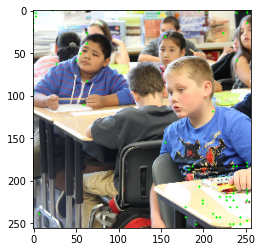

In [16]:
kps = heatmaps_to_keypoints(preds[-1,i])
plot_keypoints(np.array(imgs[i]), kps)
i += 1

In [17]:
import cv2
import imageio
def bgr_to_rgb(img):
    def helper(bgr):
        b, g, r = bgr
        return [r, g, b]

    for y in range(144):
        for x in range(256):
            img[y][x] = helper(img[y][x])

def auto_resize(image, target_size):
    h, w, _ = image.shape
    tw, th = target_size
    tar_aspect_ratio = tw / th
    
    if (w, h) == target_size:
        return image
    
    if w/h == tar_aspect_ratio:
        return cv2.resize(image, dsize=target_size)
    
    
    # figure out what needs to be cropped to get the proper aspect ratio
    if min(h, w) > min(target_size):#if image's smallest size is too large
        if max(h, w) == h: # if the height is larger cut from that
            pass




In [18]:
import imageio
print('extracting and resizing frames')
frames, _ = extract_frames('./data/test_video.mp4')

frames = np.array(frames)
frames2 = np.array(frames)

print('predicting heatmaps')
preds = np.array(model.predict(frames))

print('plotting keypoints')
for i, frame in tqdm(list(enumerate(frames))):
    avg_pred = average_heatmaps(preds[:,i])
    kps = heatmaps_to_keypoints(avg_pred)
    plot_keypoints(frame, kps, show=False)

    kps = heatmaps_to_keypoints(preds[-1,i])
    plot_keypoints(frames2[i], kps, show=False)

print('saving gifs')
imageio.mimsave('./data/awing_40k_mean.gif', frames)
imageio.mimsave('./data/awing_40k_last.gif', frames2)

extracting and resizing frames
predicting heatmaps
100%|██████████| 220/220 [01:19<00:00,  2.76it/s]
saving gifs
